In [4]:
import math, random
import gc, os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

sys.path.append("../input/iterative-stratification/iterative-stratification-master")
sys.path.append("../input/modules/datasets")
sys.path.append("../input/modules/facebookresearch")
sys.path.append("../input/modules/Qwicen")
sys.path.append("../input/modules/trainer")
sys.path.append("../input/modules/utils")
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from Tab_dataset import MoaDataset
from node import NODE
from preprocess import *
from qhoptim import QHAdam
from tab_trainer import mean_log_loss
from tab_trainer import TabTrainer

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [90]:
train_features = pd.read_csv("../input/lish-moa/train_features.csv")
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_nontargets = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
ss = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [91]:
GENES = [col for col in train_features.columns if col.startswith("g-")]
CELLS = [col for col in train_features.columns if col.startswith("c-")]
config = {"QuantileTransformer": {"random_state": 1, "n_quantiles": 1000, "output_distribution": "normal"}}
# train_features, test_features = apply_rank_gauss(
#         train_features, test_features, columns=GENES + CELLS, config=config
#     )
train_features, test_features = apply_zscore(train_features, test_features, columns=GENES + CELLS)
SEED = 1
train_features, test_features = apply_pca(train_features, test_features, GENES, threshold=0.9, kind="g", SEED=1)
train_features, test_features = apply_pca(train_features, test_features, CELLS, threshold=0.9, kind="c", SEED=1)

In [87]:
pca = PCA(random_state=SEED)
columns = CELLS
pca.fit(train_features[columns])
train2 = pca.transform(train_features[columns])
test2 = pca.transform(test_features[columns])

In [92]:
pca_cols = [col for col in train_features.columns if col.startswith("pca")]
train_features, test_features = apply_zscore(
    train_features, test_features, pca_cols
)

14

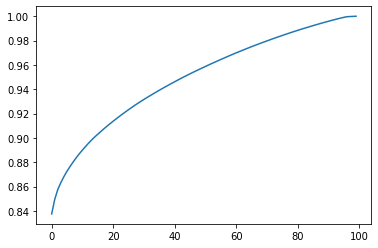

In [89]:
plt.plot(pca.explained_variance_ratio_.cumsum())
sum(pca.explained_variance_ratio_.cumsum()<0.9)

In [68]:

train_features, test_features = apply_zscore(train_features, test_features, list(test_features.columns)[4:])

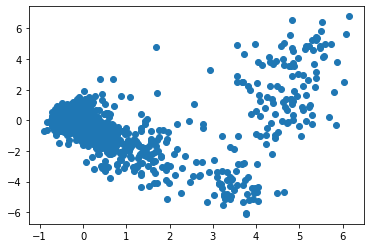

In [93]:
plt.scatter(test_features.loc[:, "pca_g-0"], test_features.loc[:, "pca_g-1"])

In [138]:
from sklearn.mixture import BayesianGaussianMixture
dpgmm = BayesianGaussianMixture(n_components=30, covariance_type='diag', max_iter=100, random_state=1, n_init=1, weight_concentration_prior_type="dirichlet_process")
dpgmm.fit(train_features.iloc[:, 4:])

BayesianGaussianMixture(covariance_type='diag', n_components=30, random_state=1)

In [139]:
train_proba = dpgmm.predict_proba(train_features.iloc[:, 4:])
test_proba = dpgmm.predict_proba(test_features.iloc[:, 4:])

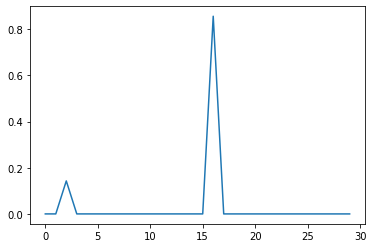

In [140]:
plt.plot(range(30), dpgmm.weights_)

In [121]:
sum(dpgmm.weights_ > 0.02)

13

In [143]:
import joblib
with open("dpgmm.job", "wb") as f:
    joblib.dump(dpgmm, f)
with open("dpgmm.job", "rb") as f:
    load_dpgmm = joblib.load(f)

In [142]:
load_dpgmm = BayesianGaussianMixture(n_components=30, covariance_type='full', max_iter=100, random_state=1, n_init=1, weight_concentration_prior_type="dirichlet_process")
load_dpgmm.set_params(**load_param)

TypeError: set_params() argument after ** must be a mapping, not method

In [147]:
proba = load_dpgmm.predict_proba(test_features.iloc[:, 4:])

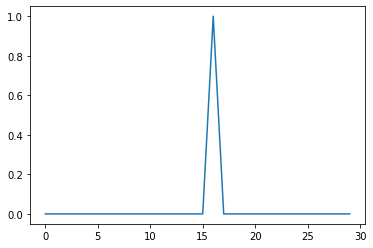

In [148]:
plt.plot(proba[0])

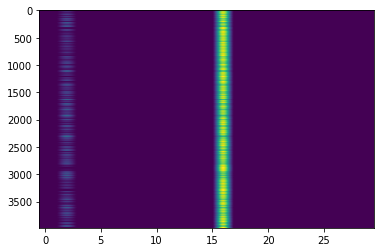

In [150]:
plt.imshow(proba, aspect="auto")